In [6]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

import pandas as pd
import os

train_path = '/content/drive/MyDrive/NNDL_HW2_After_Augment/Train/'
train_path = '/content/drive/MyDrive/NNDL_HW2_After_Augment/'

train1 = '/content/drive/MyDrive/NNDL_HW2_After_Augment/Train/Cats/'
train2 = '/content/drive/MyDrive/NNDL_HW2_After_Augment/Train/Dogs/'

files1 = [f for f in os.listdir(train1) if os.path.isfile(os.path.join(train1 , f))]
files2 = [f for f in os.listdir(train2) if os.path.isfile(os.path.join(train2 , f))]


print(f"Number of files in {train1} After Augmentation : {len(files1)}")
print(f"Number of files in {train2} Before Augmentation : {len(files2)}")

print('--------------------------------------------')

print(f"Number of files in {train_path} After Augmentation : {len(files1) + len(files2)}")
# print(f"Number of files in {test_path} Before Augmentation : {len(files2)}")


# all_test_path = '/content/drive/MyDrive/HW2_Dataset/Test/'
# test_path = '/content/drive/MyDrive/HW2_Dataset/Test/'

# files1 = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]
# files2 = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# test_files = [f for f in os.listdir(all_test_path) if os.path.isfile(os.path.join(all_test_path, f))]


# print('-----------------------------------------------')
# print(f'Number of files in {test_path} : {len(test_files)}')

# df.head()

Mounted at /content/drive
Number of files in /content/drive/MyDrive/NNDL_HW2_After_Augment/Train/Cats/ After Augmentation : 1400
Number of files in /content/drive/MyDrive/NNDL_HW2_After_Augment/Train/Dogs/ Before Augmentation : 1408
--------------------------------------------
Number of files in /content/drive/MyDrive/NNDL_HW2_After_Augment/ After Augmentation : 2808


# Before Augment

Epoch 1/50, Train Loss: 3.0246, Val Loss: 7.2258, Train Acc: 0.8130, Val Acc: 0.9377
Test Accuracy: 0.9600
Test Accuracy: 0.9600
Epoch 2/50, Train Loss: 0.9694, Val Loss: 7.8261, Train Acc: 0.8936, Val Acc: 0.9591
Test Accuracy: 0.9700
Test Accuracy: 0.9700
Epoch 3/50, Train Loss: 0.4197, Val Loss: 4.1521, Train Acc: 0.9394, Val Acc: 0.9662
Test Accuracy: 0.9700
Test Accuracy: 0.9700
Epoch 4/50, Train Loss: 1.0523, Val Loss: 4.4826, Train Acc: 0.9443, Val Acc: 0.9609
Test Accuracy: 0.9700
Test Accuracy: 0.9700
Epoch 5/50, Train Loss: 0.7449, Val Loss: 3.2714, Train Acc: 0.9470, Val Acc: 0.9733
Test Accuracy: 0.9800
Test Accuracy: 0.9800
Epoch 6/50, Train Loss: 0.4605, Val Loss: 2.2320, Train Acc: 0.9497, Val Acc: 0.9751
Test Accuracy: 0.9800
Test Accuracy: 0.9800
Epoch 7/50, Train Loss: 0.2118, Val Loss: 2.1845, Train Acc: 0.9564, Val Acc: 0.9786
Test Accuracy: 0.9700
Test Accuracy: 0.9700
Epoch 8/50, Train Loss: 0.3618, Val Loss: 1.0830, Train Acc: 0.9662, Val Acc: 0.9858
Test Accurac

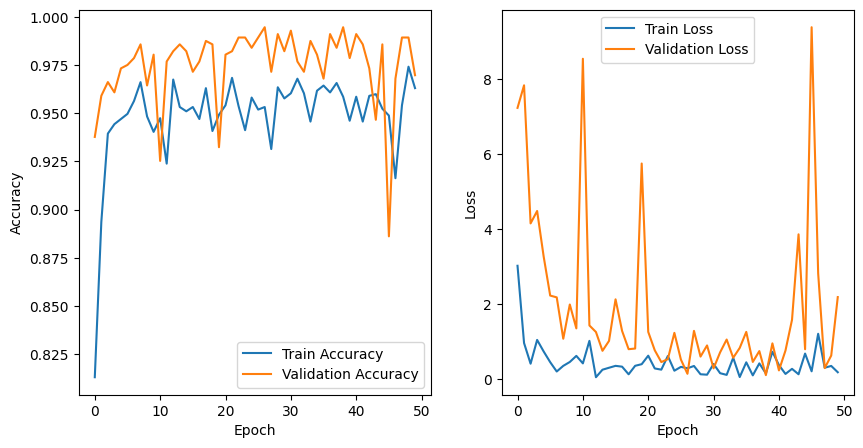

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

def train_resnet(train_path, test_path, learning_rate, momentum, num_epochs, batch_size, min_batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the datasets
    train_dataset = datasets.ImageFolder(train_path, transform=transform)
    test_dataset = datasets.ImageFolder(test_path, transform=transform)

    # Split the training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load pre-trained ResNet model
    model = models.resnet18(pretrained=True).to(device)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 2).to(device)

    # Define loss function and optimizer with momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Training loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            if i % min_batch_size == 0:
                optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            if (i+1) % min_batch_size == 0 or i == len(train_loader)-1:
                optimizer.step()
                running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_loss = val_running_loss / len(val_loader)
            val_accuracy = correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        # Test the model on the test set
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total_test += labels.size(0)
              correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test

        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # Plotting accuracy and loss graphs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_accs, label='Train Accuracy')
    plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage:
# train_path = 'path_to_train_folder'
# test_path = 'path_to_test_folder'

train_path = '/content/drive/MyDrive/NNDL_HW2_After_Augment/Train/'
test_path = '/content/drive/MyDrive/HW2_Dataset/Test/'

learning_rate = 0.1
momentum = 0.9
num_epochs = 50
batch_size = 10
min_batch_size = 10

train_resnet(train_path, test_path, learning_rate, momentum, num_epochs, batch_size, min_batch_size)

# Before Augment

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Epoch 1/50, Train Loss: 1.9234, Val Loss: 29.8551, Train Acc: 0.6524, Val Acc: 0.7234
Epoch 2/50, Train Loss: 0.5005, Val Loss: 5.1919, Train Acc: 0.8271, Val Acc: 0.9149
Epoch 3/50, Train Loss: 1.5764, Val Loss: 14.5609, Train Acc: 0.9055, Val Acc: 0.9007
Epoch 4/50, Train Loss: 3.5766, Val Loss: 0.5558, Train Acc: 0.9073, Val Acc: 0.9716
Epoch 5/50, Train Loss: 3.5519, Val Loss: 1.6524, Train Acc: 0.9216, Val Acc: 0.9787
Epoch 6/50, Train Loss: 0.3101, Val Loss: 1.4973, Train Acc: 0.9447, Val Acc: 0.9858
Epoch 7/50, Train Loss: 0.8157, Val Loss: 1.7698, Train Acc: 0.9394, Val Acc: 0.9787
Epoch 8/50, Train Loss: 3.1605, Val Loss: 2.2696, Train Acc: 0.9198, Val Acc: 0.9645
Epoch 9/50, Train Loss: 1.3767, Val Loss: 3.1320, Train Acc: 0.9465, Val Acc: 0.9787
Epoch 10/50, Train Loss: 1.1009, Val Loss: 2.1726, Train Acc: 0.9394, Val Acc: 0.9645
Epoch 11/50, Train Loss: 1.3639, Val Loss: 3.2737, Train Acc: 0.9554, Val Acc: 0.9787
Epoch 12/50, Train Loss: 0.3531, Val Loss: 3.6450, Train Acc:

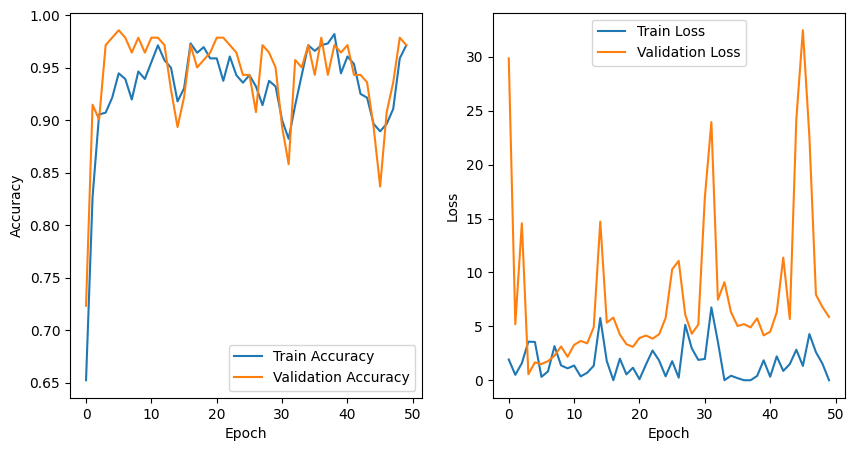

In [ ]:

train_path = '/content/drive/MyDrive/HW2_Dataset/Train/'
test_path = '/content/drive/MyDrive/HW2_Dataset/Test/'

learning_rate = 0.1
momentum = 0.9
num_epochs = 50
batch_size = 10
min_batch_size = 10

train_resnet(train_path, test_path, learning_rate, momentum, num_epochs, batch_size, min_batch_size)